Initial shape: (9471, 17)
Missing values per column:
Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64
Shape after handling missing values: (9471, 15)
Features shape: (9471, 12)
Labels shape: (9471,)
Original number of features: 12
Reduced number of features: 6


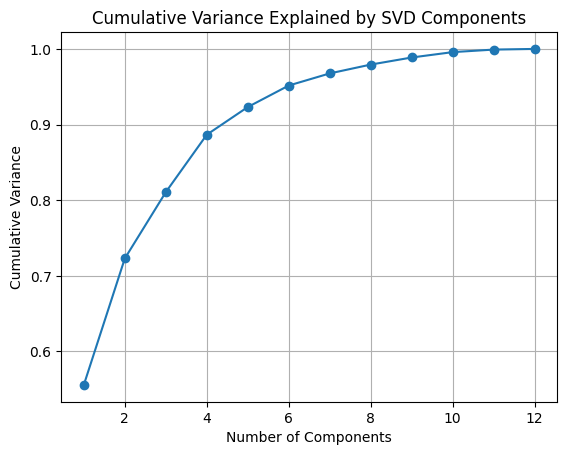

Number of components to retain (95% variance): 6
Mean Squared Error: 0.018532345538956635
R-squared: 0.8782019164901376


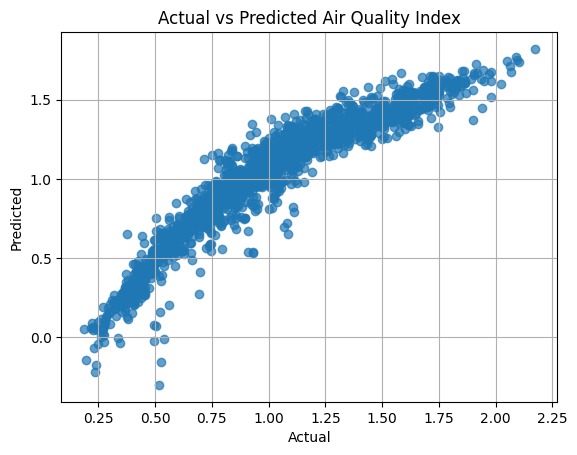

Top features for PC1 (Explained Variance: 0.56): ['PT08.S2(NMHC)', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S5(O3)', 'CO(GT)']
Top features for PC2 (Explained Variance: 0.17): ['T', 'RH', 'PT08.S4(NO2)', 'NOx(GT)', 'NO2(GT)']
Top features for PC3 (Explained Variance: 0.09): ['RH', 'NO2(GT)', 'PT08.S4(NO2)', 'NOx(GT)', 'PT08.S1(CO)']
Top features for PC4 (Explained Variance: 0.08): ['NMHC(GT)', 'PT08.S4(NO2)', 'T', 'NOx(GT)', 'RH']
Top features for PC5 (Explained Variance: 0.04): ['PT08.S3(NOx)', 'CO(GT)', 'NOx(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
Top features for PC6 (Explained Variance: 0.03): ['T', 'RH', 'NOx(GT)', 'PT08.S3(NOx)', 'C6H6(GT)']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.linalg import svd

# Load the dataset (replace with your dataset's path)
data_path = "/content/sample_data/AirQualityUCI.csv"
df = pd.read_csv(data_path, sep=";", decimal=",")

# Data preprocessing
print("Initial shape:", df.shape)

# Replace placeholder values for missing data
df = df.replace(-200, np.nan)

# Debugging: Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Drop completely empty columns (like 'Unnamed')
df = df.dropna(axis=1, how='all')

# Handle missing values: Fill NaN with the column mean for numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

print("Shape after handling missing values:", df.shape)

# Select features and labels
features = df.select_dtypes(include=[np.number]).iloc[:, :-1]  # All numerical columns except the last
labels = df.select_dtypes(include=[np.number]).iloc[:, -1]    # The last numerical column as target

# Debugging: Check the shape after preprocessing
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

# Ensure there are no NaN values remaining in the features
if features.isnull().sum().sum() > 0:
    print("NaN values found in features, replacing with column means.")
    features = features.fillna(features.mean())

# Standardize the data
features = (features - features.mean()) / features.std()

# Dimensionality reduction using PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
features_pca = pca.fit_transform(features)
print("Original number of features:", features.shape[1])
print("Reduced number of features:", features_pca.shape[1])

# Dimensionality reduction using SVD
U, S, Vt = svd(features, full_matrices=False)
singular_values = S
explained_variance = np.square(S) / np.sum(np.square(S))
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.title('Cumulative Variance Explained by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.show()

# Select top components (retain 95% variance)
n_components_svd = np.argmax(cumulative_variance >= 0.95) + 1
print("Number of components to retain (95% variance):", n_components_svd)
features_svd = U[:, :n_components_svd] @ np.diag(S[:n_components_svd])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# Build a regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title('Actual vs Predicted Air Quality Index')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid()
plt.show()

# Feature importance (PCA components)
components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

# Display top contributing features for each principal component
for i, (component, variance_ratio) in enumerate(zip(components, explained_variance_ratio)):
    sorted_indices = np.argsort(np.abs(component))[::-1]
    sorted_features = [features.columns[idx] for idx in sorted_indices[:5]]
    print(f"Top features for PC{i+1} (Explained Variance: {variance_ratio:.2f}): {sorted_features}")
